# Dynamic Weather Sensitivity in NEWT

Major departures in watershed conditions are often well past routine weather swings.  However, modeling variable seasonality still tends to miss peaks and a lot of variation throughout the spring and summer, so what's going on there?  New hypothesis: it's still weather sensitivity, but non-stationary weather sensitivity.  A snowy watershed is still a snowy watershed, but with a dry winter it ends up being much more sensitive to warm days.  Notably, a lot of the missed peaks in Eagle River are big, short spikes that the stationary model catches, but underestimates.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from NEWT import Watershed as WS
import NEWT.analysis as analysis
import NEWT
import warnings

def trycatch(op):
    try:
        return op()
    except ValueError:
        return None

In [2]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data["date"] = pd.to_datetime(data["date"])

def get_candidate(cid):
    return data[data["id"] == cid]

In [3]:
# This is Eagle River Below Milk Creek Near Wolcott, CO
# Appears to be unregulated, freezes in winter, max temperature ~20 C, discharge ~50-2000 cfs,
# elevation ~2100 m
candidate_eagle = "394220106431500"

cid = candidate_eagle
csd = get_candidate(cid).assign(year = lambda x: x["date"].dt.year,
                               day = lambda x: x["date"].dt.day_of_year)

## Eagle River AT Anomaly

For a first test, let's look at AT anomaly alone, which is easy to extract by setting VP coefficient to zero and AT coefficient to 1.

Years to focus on are 2010, 2012, 2013, 2015, 2018, 2021, and 2022.

In [4]:
mod = WS.from_data(csd)
mod.vp_coef = 0
mod.at_coef = 1
pred = mod.run_series(csd).assign(st_anom = lambda x: x["temperature"] - x["actemp"])

<Axes: >

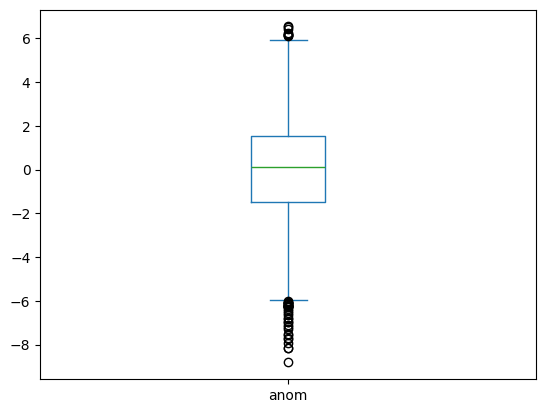

In [5]:
# ax = sns.lineplot(x="date", y="temperature", data=pred)
# sns.lineplot(x="date", y="actemp", data=pred, ax=ax)
pred["anom"].plot.box()

At a glance, there are three "bundles": one more responsive (mean ~ 0, contains the largest positive anomalies of 1.5-3 C), one less responsive (mean < 0), and one more responsive with mean << 0.  It seems that different years do have discrete slopes, plus a constant offset (better handled by modeling Intercept using an established year-engine).  Here, I'll focus on slope, not Intercept.

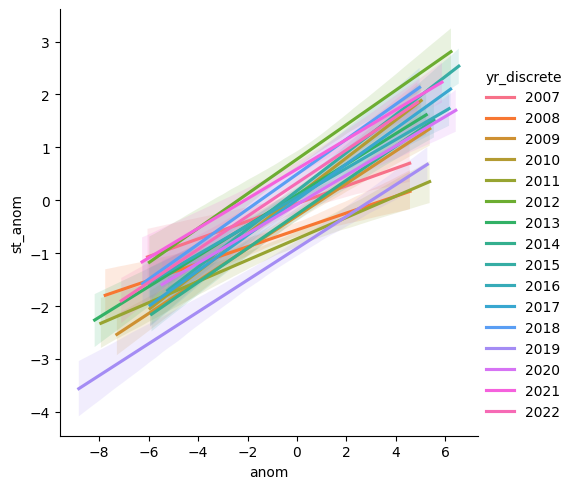

In [6]:
pred["yr_discrete"] = pred["year"].apply(str)
# fig = plt.figure(figsize=(12,8))
# ax = plt.axes()
sns.lmplot(x="anom", y="st_anom", data=pred, hue="yr_discrete", scatter=False)

Let's try that by month, not year - as a proxy for seasonal effect.

Now *that's* more interesting.

- In December and January, sensitivity is ~0 (it's frozen), which probably throws off the regression to begin with.
- Then, we see a wide range of monthly sensitivities, ranging from about 1:1 in July to about 1:4 in some months.

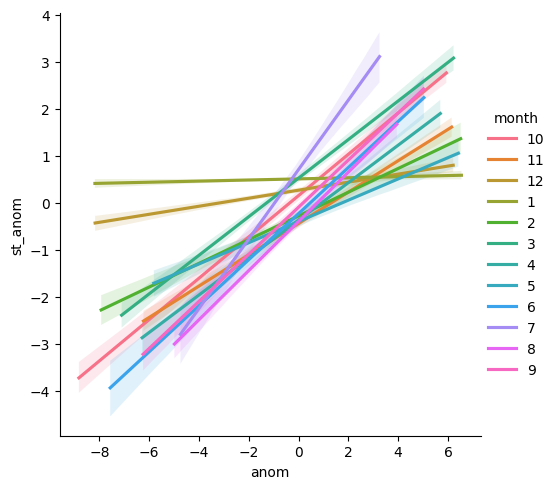

In [7]:
pred["month"] = pred["date"].dt.month.apply(str)
# fig = plt.figure(figsize=(12,8))
# ax = plt.axes()
sns.lmplot(x="anom", y="st_anom", data=pred, hue="month", scatter=False)

## Slope Modeling

In [4]:
def fit_slope(data):
    # data = data[(data["day"] > 150) & (data["day"] < 270)]
    x = data["anom"].to_numpy()
    x = np.array([np.ones(x.shape), x]).transpose()
    y = data["st_anom"].to_numpy()
    return np.linalg.lstsq(x, y, rcond=None)[0][1]

As a general comment, there is non-trivial variation in the slopes.  The non-outlier range of weighted anomalies is about $\pm$6 degrees, so the non-outlier anomaly range here of 0.2-0.35 could explain missing a peak by up to a degree.  That doesn't fully explain it, but it's certainly a start.

Limited to day 150-270, the IQR is small but the outlier range is huge, 0-0.8.

By month, slopes range from ~0 to 0.7, with an IQR of 0.2-0.5.

And there looks to be a pretty solid ~logarithmic (or square root?) relationship between monthly mean temperature and response sensitivity.  This one actually looks more like a threshold behavior, where sensitivity is roughly constant from mean temperatures of 3 C upwards and scales linearly below that.

<Axes: xlabel='mean', ylabel='slope'>

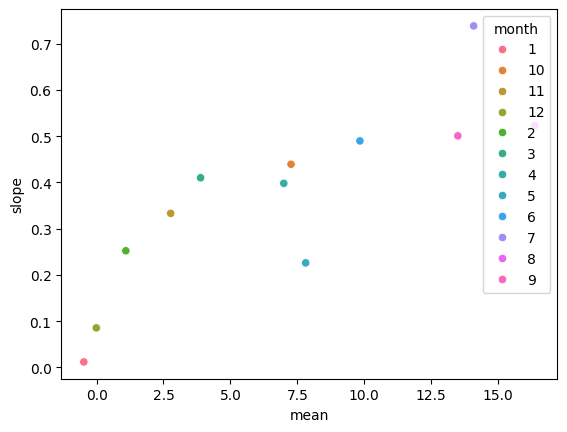

In [9]:
slopes = pred.groupby("month").apply(lambda x: pd.DataFrame({"slope": fit_slope(x), "mean": [x["actemp"].mean()]}), include_groups=False)
slopes["exp"] = np.exp(slopes["slope"])
slopes["sqr"] = slopes["slope"]**2
slopes["month"] = slopes.index.get_level_values(0)
sns.scatterplot(x="mean", y="slope", data=slopes, hue="month")

For Eagle River, a whopping $R^2$ of 0.65 is attainable just on `tmax`, specifically from day 330-90.  So how does that affect performance?  Maximum $R^2$ is much lower with just summer coefficient, so that's not promising.

<Axes: xlabel='slope', ylabel='pred_slope'>

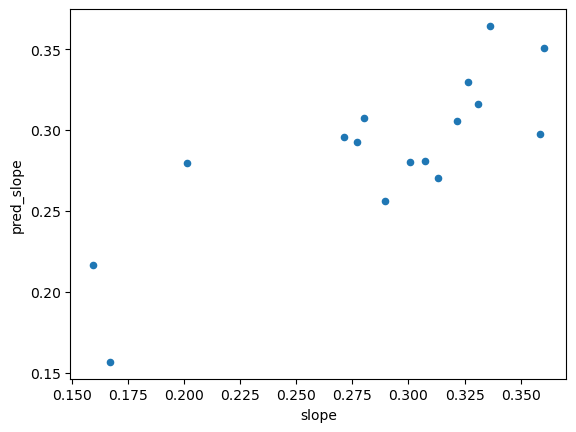

In [14]:
weather.plot.scatter(x="slope", y="pred_slope")

In [15]:
pred = pred.merge(weather["pred_slope"], on="year")

In [16]:
pred["st_base"] = pred["actemp"] + pred["st_anom"] * 0.3  # median
pred["st_fit"] = pred["actemp"] + pred["st_anom"] * pred["pred_slope"]
pred

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,year,day,actemp,anom,temp.mod,st_anom,yr_discrete,pred_slope,st_base,st_fit
0,394220106431500,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,2007,274,10.141775,0.017104,10.158879,-1.141775,2007,0.156549,9.799242,9.963031
1,394220106431500,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,2007,275,9.872676,-0.053857,9.818819,0.258574,2007,0.156549,9.950248,9.913156
2,394220106431500,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,2007,276,9.602529,-0.046952,9.555577,0.101637,2007,0.156549,9.633020,9.618441
3,394220106431500,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,2007,277,9.331561,0.198004,9.529565,0.364273,2007,0.156549,9.440843,9.388587
4,394220106431500,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,2007,278,9.059998,0.806556,9.866555,1.841043,2007,0.156549,9.612311,9.348212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,394220106431500,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,2022,361,-0.555511,2.185967,1.630456,0.555511,2022,0.270649,-0.388857,-0.405162
5535,394220106431500,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,2022,362,-0.580520,3.529477,2.948957,0.580520,2022,0.270649,-0.406364,-0.423403
5536,394220106431500,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,2022,363,-0.602905,3.164175,2.561270,0.602905,2022,0.270649,-0.422034,-0.439729
5537,394220106431500,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,2022,364,-0.622671,0.116842,0.000000,0.622671,2022,0.270649,-0.435870,-0.454146


In [17]:
pred[["temperature", "actemp", "st_base", "st_fit"]].corr()**2

,temperature,actemp,st_base,st_fit
temperature,1.000000,0.927741,0.964592,0.964053
actemp,0.927741,1.000000,0.993150,0.993252
st_base,0.964592,0.993150,1.000000,0.999903
st_fit,0.964053,0.993252,0.999903,1.000000


Slope-fitting actually produces a slight penalty to R2, but how does it impact max-capture?

<Axes: >

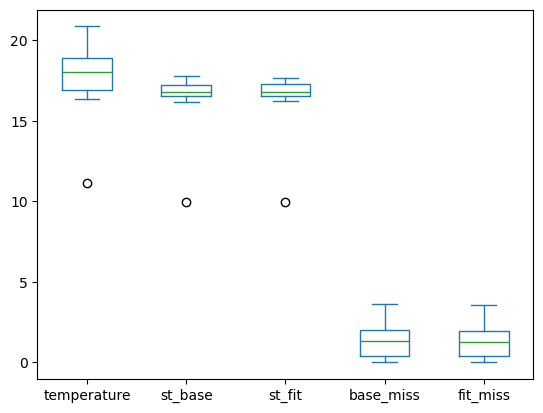

In [18]:
pred.groupby("year")[["temperature", "st_base", "st_fit"]].max().assign(base_miss = lambda x: x["temperature"] - x["st_base"], fit_miss = lambda x: x["temperature"] - x["st_fit"]).plot.box()

<Axes: >

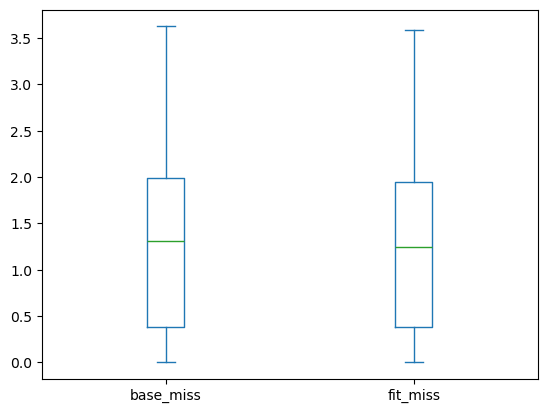

In [19]:
pred.groupby("year")[["temperature", "st_base", "st_fit"]].max().assign(base_miss = lambda x: x["temperature"] - x["st_base"], fit_miss = lambda x: x["temperature"] - x["st_fit"])[["base_miss", "fit_miss"]].plot.box()

There's a nonzero benefit, but small.  What if we look at midyear temperatures only?

Actually, one last idea: let's plot errors against all variables.

In [85]:
pred["error"] = pred["st_base"] - pred["temperature"]

## Seasonally-Linked Sensitivity

Is sensitivity linked to seasonality in general?

In [5]:
def make_coefs(data):
    try:
        mod = WS.from_data(data)
        mod.vp_coef = 0
        mod.at_coef = 1
        return mod.run_series(data).assign(st_anom = lambda x: x["temperature"] - x["actemp"])
    except:
        return None

def make_slope(data):
    slope = fit_slope(data)
    mean = data["actemp"].mean()
    return pd.DataFrame({"slope": [slope], "mean": mean})

data["month"] = data["date"].dt.month
slopes = data.groupby("id").apply(make_coefs, include_groups=False).groupby(["id", "month"]).apply(make_slope, include_groups=False).reset_index().drop(columns="level_2")

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\rtseason\seasons.py:132: UserWarning: Insufficient data coverage for 3-sine fit; >=180 days required
  warnings.warn("Insufficient data coverage for 3-sine fit; >=180 days required")
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\rtseason\seasons.py:132: UserWarning: Insufficient data coverage for 3-sine fit; >=180 days required
  warnings.warn("Insufficient data coverage for 3-sine fit; >=180 days required")
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\rtseason\seasons.py:132: UserWarning: Insufficient data coverage for 3-sine fit; >=180 days required
  warnings.warn("Insufficient data coverage for 3-sine fit; >=180 days required")
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\rtseason\seasons.py:132: UserWarning: Insufficient data coverage for 3-sine fit; >=180 days required
  warnings.warn("Insufficient data coverage for 3-sine fit; >=180 days required")
C:\Users\dphilippus\.con

In [6]:
slopes

,id,month,slope,mean
0,01010000,1,1.636078e-04,-0.577264
1,01010000,2,6.025298e-18,-0.445979
2,01010000,3,9.342597e-18,-0.259626
3,01010000,4,1.385763e-01,3.834396
4,01010000,5,8.525973e-01,9.839635
...,...,...,...,...
11157,453004122510301,8,5.065461e-01,19.967435
11158,453004122510301,9,3.467227e-01,17.839871
11159,453004122510301,10,3.722326e-01,13.738020
11160,453004122510301,11,8.627500e-01,9.226595


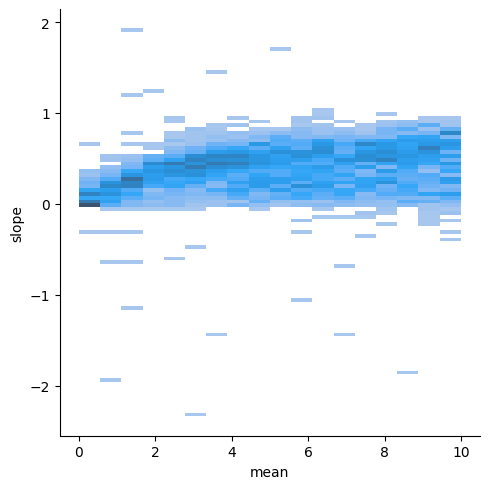

In [7]:
sns.displot(x="mean", y="slope", data=slopes[(slopes["slope"].abs() < 2.5) & (slopes["mean"] < 10) & (slopes["mean"] > 0)])

In [8]:
slopes[slopes["mean"] < 3]["mean"].corr(slopes["slope"])

0.3712544088485279

In [9]:
slopes[slopes["mean"] < 5].groupby("id").apply(lambda x: x["mean"].corr(x["slope"]), include_groups=False).describe()

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


count    548.000000
mean       0.520377
std        0.673550
min       -1.000000
25%        0.279573
50%        0.887624
75%        0.976726
max        1.000000
dtype: float64

Most sites have a weak correlation, but we saw with Eagle River that most of the response happened for low temperatures.  For the 25% of sites that *have* months with a mean below 3 C, the correlation tends to be *much* stronger, at a median of ~0.9 (R, not R2).  Note this is nearly as good for a cutoff of 5.

Next steps:

- See if there's a consistent cutoff and if the upper value is generally stable
- Summarize cutoff and stable (warm-months) value
- Compare cutoff to seasonality to see if readily computable
- Rework anomaly fitting and see how that affects performance, especially big-spike performance
- Then look into other dynamic possibilities: persistence of anomaly, etc

In [10]:
def get_slope(sl):
    x = sl["mean"]
    y = sl["slope"]
    X = np.array([np.ones(x.shape), x]).transpose()
    return np.linalg.lstsq(X, y, rcond=None)[0][1]

def get_corr(sl):
    return sl["mean"].corr(sl["slope"])

def cutoff_data(sl, cut):
    """
    For specified slope dataset and cutoff, return:
        Sub-cutoff correlation, minimum, maximum, slope
        Above-cutoff correlation, slope
    """
    sub = sl[sl["mean"] <= cut]
    abv = sl[sl["mean"] > cut]
    return {
        "cutoff": cut,
        "low_corr": get_corr(sub),
        "low_min": sub["slope"].min(),
        "low_max": sub["slope"].max(),
        "low_slope": get_slope(sub),
        "high_corr": get_corr(abv),
        "high_slope": get_slope(abv)
    }

def ssq_corr(result):
    return result["low_corr"]**2 + result["high_corr"] ** 2

def find_cutoff(sl):
    """
    sl: has mean, slope
    We want:
        Optimal cutoff point for corr., such that there are at least 3 months above and below the cutoff
        Sub-cutoff correlation, minimum, maximum, and slope
        Above-cutoff correlation and slope
        Cutoff sensitivity: sub-cor with optimal vs sub-cor with cutoff = 5
    We want to optimize both below and above-cutoff correlation, so we optimize for the sum of squares to balance it.
    """
    if len(sl) < 7:
        return {}
    means = sl["mean"].to_numpy()
    means.sort()
    min_cutoff = int(means[2]) + 1
    max_cutoff = int(means[-3])
    if max_cutoff <= min_cutoff:
        return cutoff_data(sl, min_cutoff) | {"sensitivity": np.NaN}
    best_cutoff = None
    for cutoff in range(min_cutoff, max_cutoff + 1):
        fit = cutoff_data(sl, cutoff)
        if best_cutoff is None or ssq_corr(best_cutoff) < ssq_corr(fit):
            best_cutoff = fit
    best_cutoff["net_fit"] = ssq_corr(best_cutoff)
    best_cutoff["sensitivity"] = ssq_corr(best_cutoff) - ssq_corr(cutoff_data(sl, 5)) if 5 in range(min_cutoff, max_cutoff) else np.NaN
    return best_cutoff

In [11]:
opt_cutoffs = pd.DataFrame([x for x in [{"id": n} | find_cutoff(sl) for n, sl in slopes.groupby("id")] if "low_corr" in x])

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [12]:
opt_cutoffs

,id,cutoff,low_corr,low_min,low_max,low_slope,high_corr,high_slope,net_fit,sensitivity
0,01010000,11,0.882634,6.025298e-18,1.034229,0.088957,-0.985501,-0.180887,1.750254,0.221714
1,01011000,11,0.901102,-1.114399e-03,0.904553,0.074956,-0.947874,-0.109622,1.710448,0.029263
2,01018035,5,0.959151,2.312530e-04,0.895354,0.173439,-0.820600,-0.056325,1.593355,0.000000
3,01038000,15,0.847861,7.361934e-02,0.981915,0.050833,-0.966988,-0.098424,1.653934,0.300938
4,010642505,11,0.910425,1.042993e-01,0.872747,0.065178,-0.953910,-0.081382,1.738819,0.367435
...,...,...,...,...,...,...,...,...,...,...
941,385903107210800,7,0.915220,2.578549e-01,0.485606,0.075361,0.623366,0.875652,1.226212,NaN
942,394220106431500,10,0.757361,1.180485e-02,0.738501,0.042141,-0.994965,-0.119133,1.563552,0.629948
943,402114105350101,8,0.828573,3.594187e-02,0.604126,0.056562,-0.983642,-0.144422,1.654086,0.624112
944,404417108524900,6,0.733422,3.204254e-01,0.424386,0.026312,-0.340402,-0.005807,0.653781,0.453482


In [21]:
opt_cutoffs["low_delta"] = (opt_cutoffs["low_max"] - opt_cutoffs["low_min"]) / opt_cutoffs["low_max"]
opt_cutoffs.describe()

,cutoff,low_corr,low_min,low_max,low_slope,high_corr,high_slope,net_fit,sensitivity,low_delta
count,946.000000,945.000000,946.000000,946.000000,946.000000,945.000000,946.000000,941.000000,470.000000,945.000000
mean,12.402748,0.485045,0.168890,0.722675,0.071222,-0.424009,-0.024881,1.383588,0.442093,0.740972
std,6.247247,0.680650,1.548191,0.698622,0.651081,0.709460,0.120400,0.340493,0.413716,1.477523
min,-58.000000,-0.999999,-37.967755,0.000000,-3.135969,-0.999967,-2.849235,0.173597,0.000000,0.064787
25%,8.000000,0.357470,0.076208,0.496429,0.008372,-0.938220,-0.057212,1.106784,0.060480,0.424513
50%,13.000000,0.843152,0.229164,0.721985,0.036971,-0.803510,-0.028623,1.422034,0.363163,0.612146
75%,17.000000,0.941325,0.450979,0.897227,0.076078,-0.020026,-0.000073,1.659713,0.698350,0.854469
max,31.000000,0.999996,0.910933,19.121735,18.949829,0.999991,0.875652,1.974552,1.760041,43.320781


Overall results:

- Median optimized low correlation is 0.84, at a median cutoff of 13 C
- The median low-min is about a third of low-max, so there's a big impact
- High correlations are usually negative, with a median of -0.8
- Median sensitivity is about a quarter of the potential combined fit, at 0.36 vs 1.4.  That's out of the half of sites for which a cutoff of 5 C was usable at all.

On the whole, this suggests that fitting a cutoff is wise.  Let's see how it maps to seasonality.

In [24]:
safe_df = lambda x: x.to_df() if x is not None else None
with warnings.catch_warnings(action="ignore"):
    ssn = data.groupby("id").apply(lambda x: safe_df(rts.ThreeSine.from_data(x.assign(day = lambda y: y["date"].dt.day_of_year))), include_groups=False).merge(opt_cutoffs, on="id").drop(columns=["sensitivity", "R2", "RMSE", "net_fit"])
ssn.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,cutoff,low_corr,low_min,low_max,low_slope,high_corr,high_slope,low_delta
count,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,12.671532,8.987619,326.853982,67.795723,156.730088,217.349558,0.687559,1.403623,12.129794,0.493122,0.200803,0.714880,0.064736,-0.393824,-0.021221,0.667774
std,4.948378,2.842033,16.048603,32.804644,20.565549,17.513116,1.111049,0.965138,6.353517,0.690755,1.490713,0.785980,0.168500,0.733914,0.134036,0.397887
min,-62.248353,-0.174760,300.000000,1.000000,120.000000,200.000000,-13.578274,-3.291133,-58.000000,-0.999907,-37.967755,0.019166,-1.514615,-0.999950,-2.849235,0.064787
25%,9.980740,7.215462,317.000000,33.000000,139.250000,200.000000,-0.012016,0.786136,8.000000,0.425874,0.079217,0.480590,0.009255,-0.934398,-0.050196,0.410628
50%,12.418951,9.416723,326.500000,84.000000,158.000000,211.000000,0.423882,1.421673,13.000000,0.860744,0.228927,0.708870,0.038584,-0.793925,-0.025469,0.600484
75%,15.217910,11.067765,333.000000,90.000000,180.000000,239.000000,1.263235,2.006383,16.000000,0.948033,0.450979,0.891130,0.083652,0.191613,0.003458,0.838707
max,30.215404,16.169296,365.000000,110.000000,180.000000,240.000000,4.271615,4.128983,31.000000,0.999996,0.910933,19.121735,1.955155,0.999991,0.875652,3.430429


In [23]:
ssn.corr()

,id,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,cutoff,low_corr,low_min,low_max,low_slope,high_corr,high_slope,low_delta
id,1.000000,-0.065429,-0.026112,-0.039080,0.074535,-0.002207,0.029583,0.089541,-0.008930,-0.017409,0.004127,0.000985,-0.010081,-0.018604,0.015518,0.103747,-0.002436
Intercept,-0.065429,1.000000,0.039134,0.143403,0.350385,0.334648,0.087784,-0.040668,0.108773,0.764408,-0.022170,0.643200,-0.436782,0.087375,0.037645,-0.073154,-0.413755
Amplitude,-0.026112,0.039134,1.000000,-0.430882,0.283077,-0.002100,-0.309824,-0.231965,0.442360,0.031251,0.401692,-0.015237,0.256709,0.127587,-0.465497,-0.155480,-0.089454
FallDay,-0.039080,0.143403,-0.430882,1.000000,-0.247700,0.060057,0.415405,0.160346,-0.385231,0.103039,-0.222900,0.032023,-0.236622,-0.138749,0.318189,0.105127,0.126393
WinterDay,0.074535,0.350385,0.283077,-0.247700,1.000000,0.502732,-0.196080,-0.290347,0.197811,0.336883,0.051871,0.146515,0.073940,-0.114600,-0.087468,-0.018392,-0.304323
SpringDay,-0.002207,0.334648,-0.002100,0.060057,0.502732,1.000000,0.082852,-0.268158,0.040323,0.321422,-0.147012,0.097544,0.044306,-0.181811,0.163495,0.098610,-0.274811
SummerDay,0.029583,0.087784,-0.309824,0.415405,-0.196080,0.082852,1.000000,0.213224,-0.483530,0.134970,-0.198475,0.007629,-0.113485,-0.163518,0.212726,0.079232,0.047337
SpringSummer,0.089541,-0.040668,-0.231965,0.160346,-0.290347,-0.268158,0.213224,1.000000,-0.144259,-0.090156,0.010153,0.422707,-0.550017,0.233657,-0.018667,-0.081317,0.142079
FallWinter,-0.008930,0.108773,0.442360,-0.385231,0.197811,0.040323,-0.483530,-0.144259,1.000000,-0.076881,0.245234,0.058472,0.101080,0.251611,-0.250501,-0.056102,-0.133607
cutoff,-0.017409,0.764408,0.031251,0.103039,0.336883,0.321422,0.134970,-0.090156,-0.076881,1.000000,-0.183271,0.489301,-0.247353,-0.201969,0.092457,-0.086179,-0.324255


Early takeaways:

- Slope of the upper part is usually not very important, and it's probably safer to avoid predicting that - assume constant.  If that is assumed constant, then fitting sensitivity also gets us `low_max` and the high value.
- Cutoff is relatively predictable from Intercept.  WinterDay and SpringDay have non-trivial relevance too, but they're hard to predict themselves.
- Low_min is typically 20-60% of low_max, but the ratio is less predictable than either low_min or low_max.  Low_slope is not predictable from seasonality.

From that, I think it makes the most sense to predict the cutoff (using Intercept, and possibly WinterDay/SpringDay), low_min, and low_max (low_max ~ sensitivity), from which we can construct the full sensitivity curve.  Cutoff and low_min can be estimated from seasonality, though I'll also try fitting them directly, while low_max is fitted directly.  For fitting models from data, of course, we can fit them directly.

## Threshold Sensitivity Implementation Testing

In [4]:
anom = NEWT.watershed.anomilize(csd).assign(anom_atmod = lambda x: analysis.convolve(x["at_anom"]))

<Axes: xlabel='int_mean', ylabel='slope'>

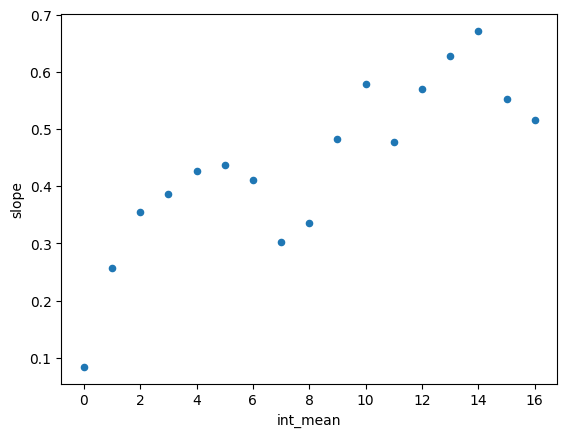

In [8]:
sens = analysis.get_sensitivities(anom).rename(columns={None: "slope"})
sens.plot.scatter(x="int_mean", y="slope")

In [9]:
analysis.find_cutoff(sens)

{'cutoff': 3,
 'corr': 0.9537639313098882,
 'min': 0.08398790670940671,
 'max': 0.3855598823330011}